# CellRank pipeline with CytoTrace Kernel

In [55]:
import sys
#!pip install -q git+https://github.com/theislab/cellrank
import cellrank as cr
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import numpy as np

In [56]:
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [57]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

### Initialization 

In [58]:
adata = sc.read("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Matrix/p2.h5ad")
adata

AnnData object with n_obs × n_vars = 54606 × 18723
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'timepoint', 'doublet_finder', 'percent.mt', 'qc_pass', 'RNA_snn_res.0.1', 'seurat_clusters', 'RNA.weight', 'ADT.weight', 'wsnn_res.0.1', 'SingleR', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'manual_annotation', 'final_annot', 'annotation', 'Annotation'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    uns: 'neighbors'
    obsm: 'X_adt.umap', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_tsne', 'X_umap', 'X_wnn.umap'
    varm: 'PCs'
    obsp: 'distances'

In [59]:
print(f"This detected {adata.var['vf_vst_counts_variable'].sum()} highly variable genes. ")

This detected 2000 highly variable genes. 


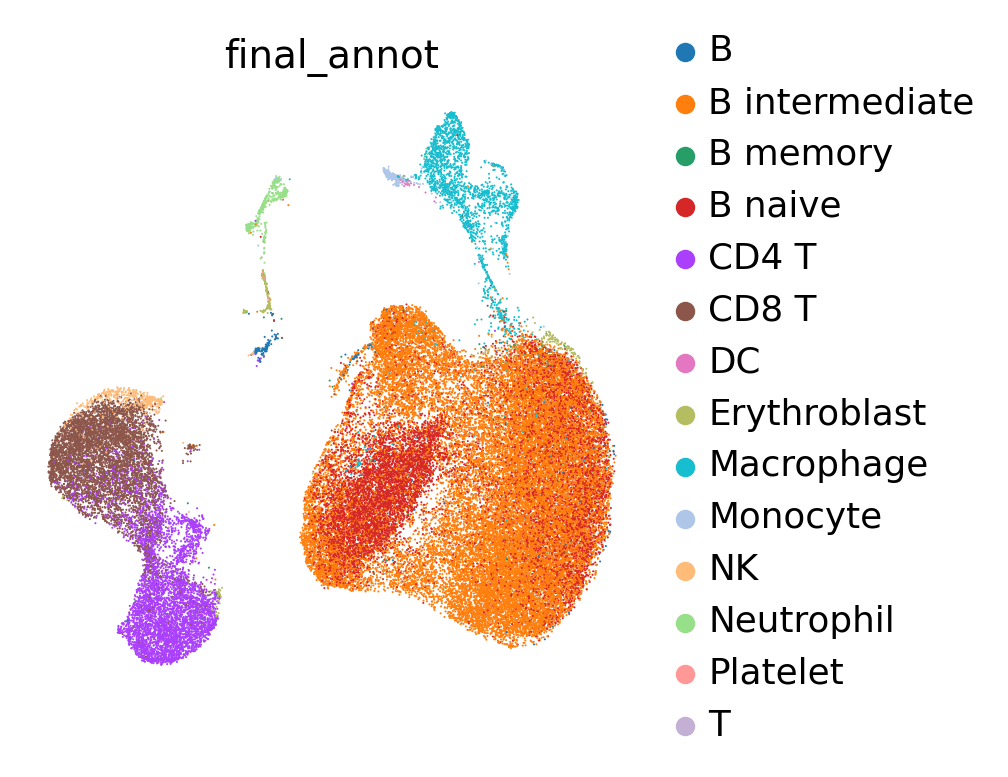

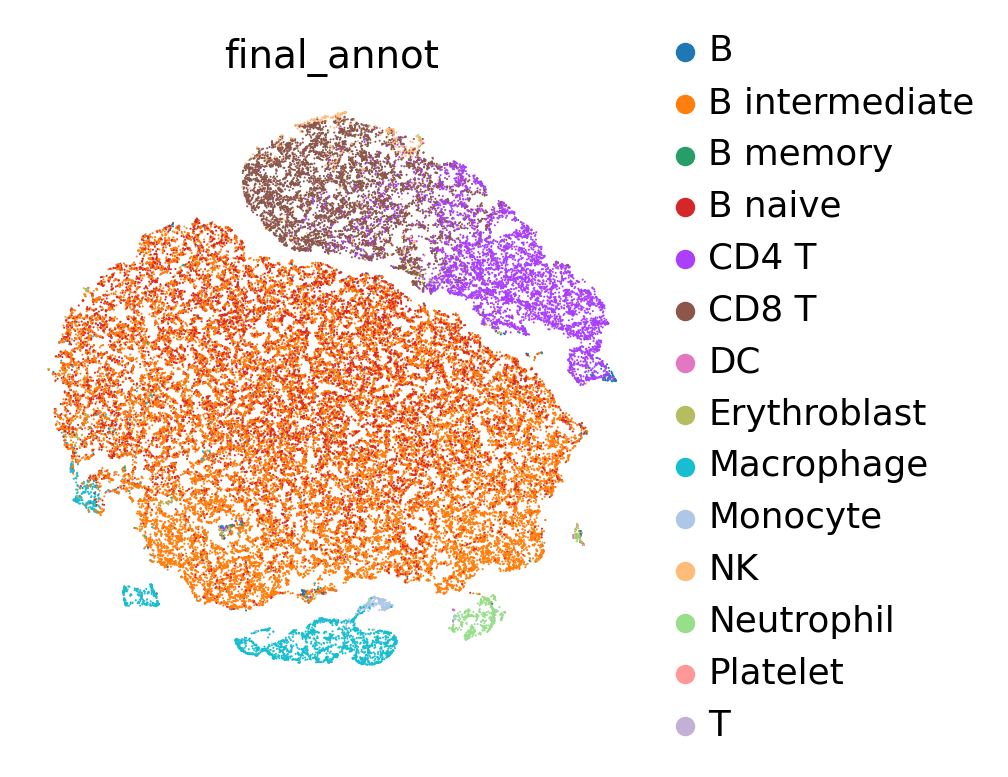

In [60]:
sc.pl.embedding(adata, basis="X_umap", color=["final_annot"])
sc.pl.embedding(adata, basis="X_tsne", color=["final_annot"])

In [61]:
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

/tmp/ipykernel_30308/3936592386.py:3: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:01:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Compute the CytoTRACE score : Kernel

In [89]:
cell_types_to_keep = [ 'B intermediate', 'B memory', 'B naive', 'Bridge', 'Monocyte', 'Macrophage',]
adata = adata[adata.obs['Annotation'].isin(cell_types_to_keep)].copy()
sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=30)

computing neighbors
    finished (0:00:04)


In [90]:
from cellrank.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata).compute_cytotrace()

Computing CytoTRACE score with `18723` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:02)


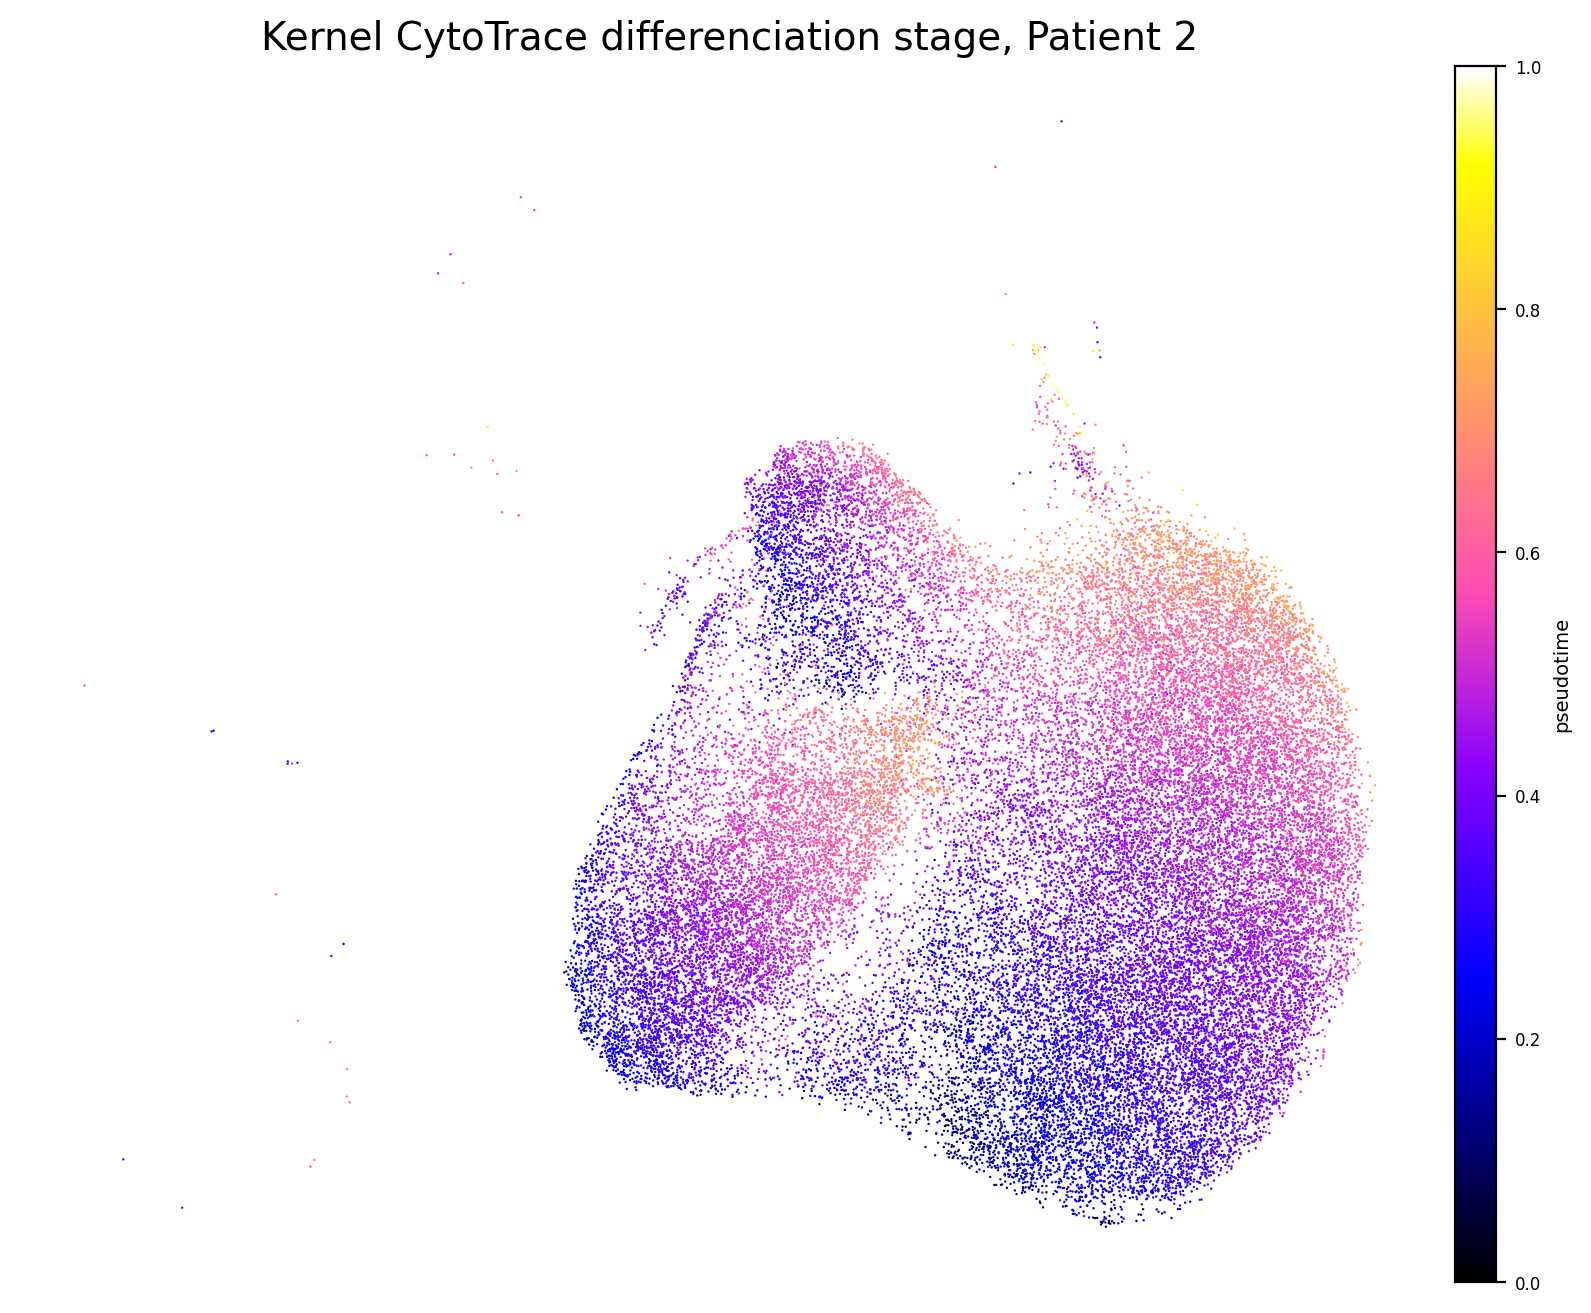

In [91]:
fig, ax = plt.subplots(figsize=(10, 8))

sc.pl.embedding(
    adata,
    color=["ct_pseudotime"],
    basis="umap",
    color_map="gnuplot2",
    title="Kernel CytoTrace differenciation stage, Patient 2",
    ax=ax,
    show=False,
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.set_label("pseudotime", fontsize=7)

plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/cytotrace_umap_p2.png", dpi=300, bbox_inches='tight')
plt.show()

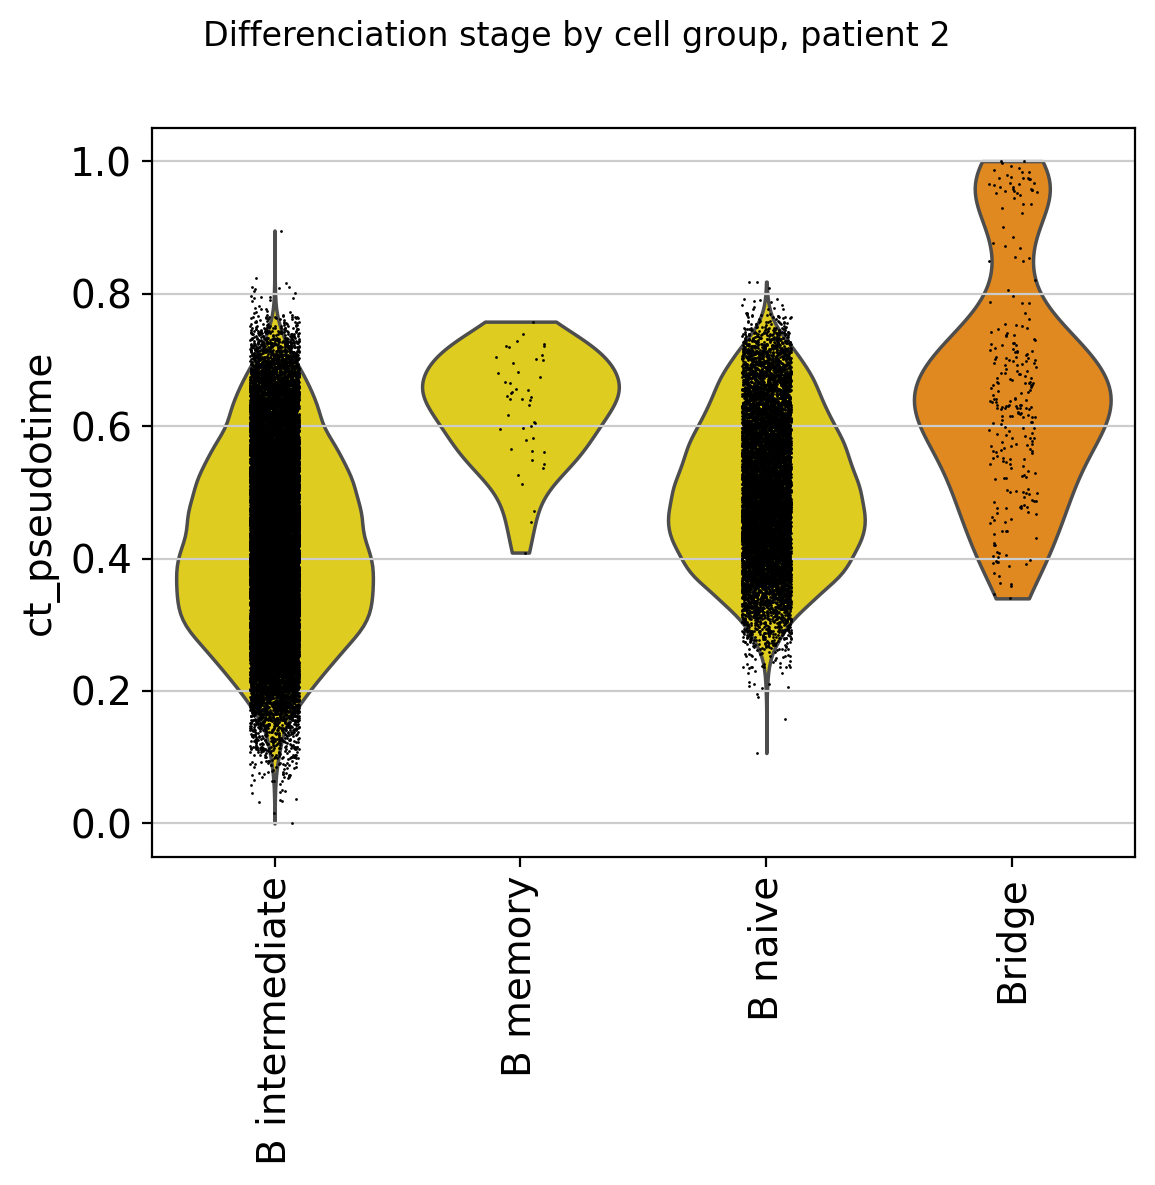

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))

sc.pl.violin(
    adata,
    keys=["ct_pseudotime"],
    groupby="Annotation",
    rotation=90,
    palette=["#FFE500", "#FFE500", "#FFE500", "#FF8C00", "#0E0AF5", "#0E0AF5"],
    ax=ax,
    show=False,
)

plt.suptitle("Differenciation stage by cell group, patient 2", fontsize=12, y=0.99)
plt.tight_layout()
plt.savefig(
    "/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/cytotrace_violin_p2.png",
    dpi=300,
    bbox_inches='tight'
)
plt.show()

### Compute & visualize a transition matrix

In [93]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing transition matrix based on pseudotime


  0%|                                               | 0/39685 [00:00<?, ?cell/s]/home/a.blanc-boekholt/miniconda3/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=30308) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
100%|████████████████████████████████| 39685/39685 [00:03<00:00, 11223.39cell/s]


    Finish (0:00:05)


CytoTRACEKernel[n=39685, dnorm=False, scheme='soft', b=10.0, nu=0.5]

Using precomputed projection `adata.obsm['T_fwd_umap']`


/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-package

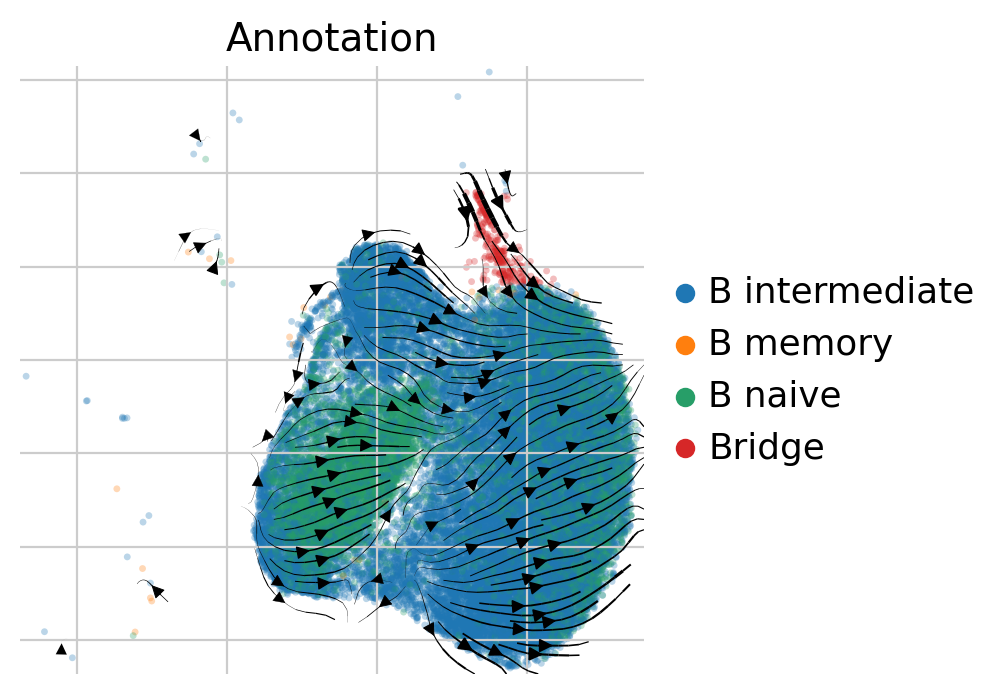

In [94]:
ctk.plot_projection(basis="X_umap", color="Annotation", legend_loc="right")

Using precomputed projection `adata.obsm['T_fwd_umap']`


/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/a.blanc-boekholt/miniconda3/lib/python3.13/site-package

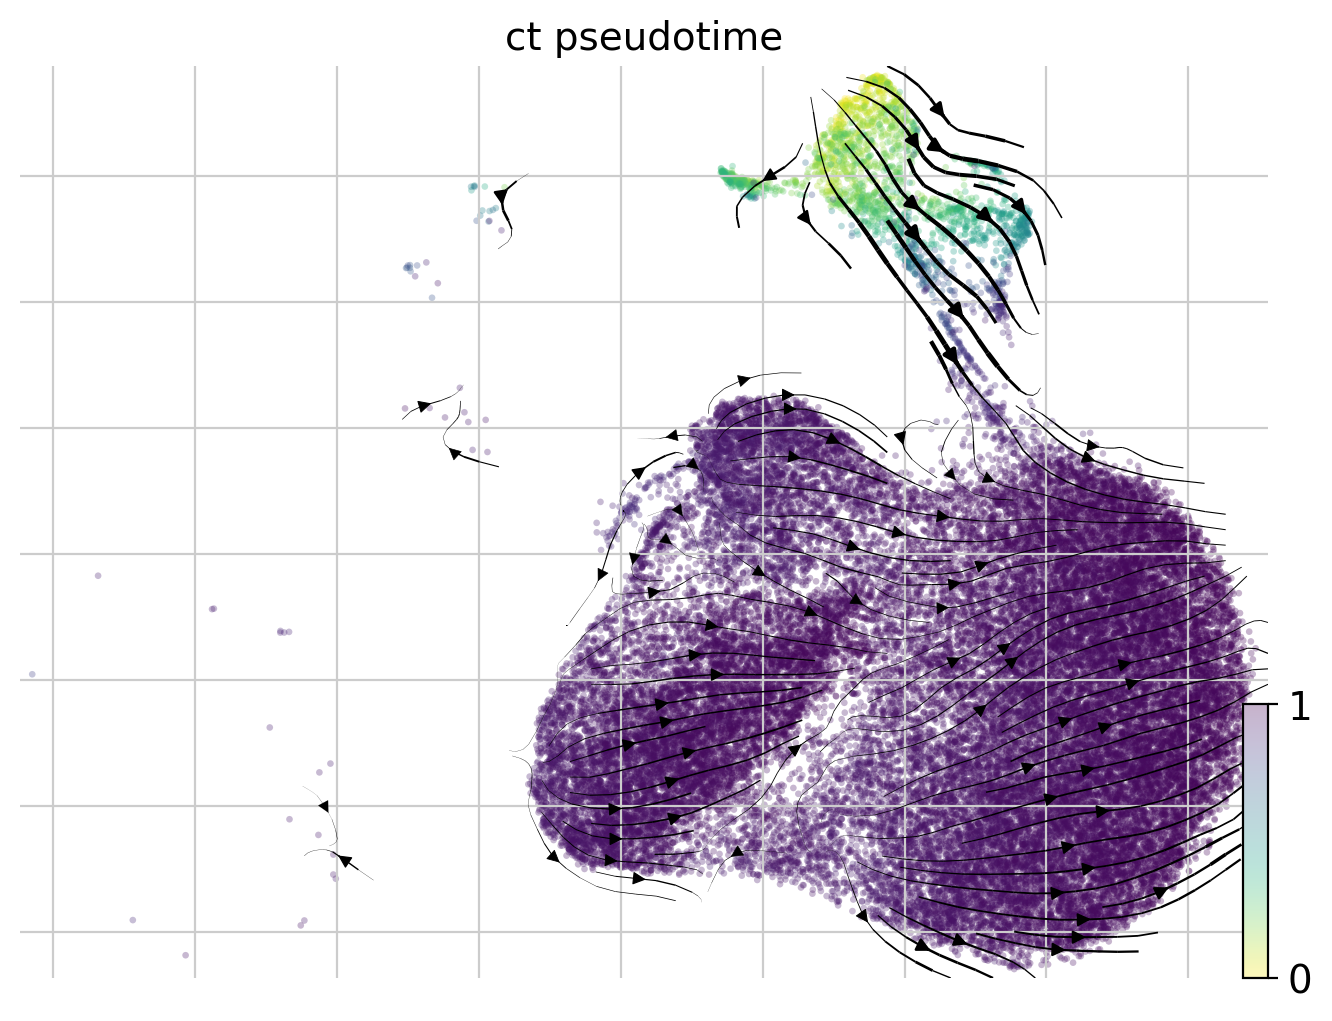

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

ctk.plot_projection(
    basis="X_umap",
    legend_loc="right",
    color="ct_pseudotime",
    ax=ax                
)

fig.suptitle("Streamlines, patient 2", fontsize=12, y=0.99)
fig.tight_layout()

fig.savefig(
    "/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/cytotrace_proj_p2.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


In [82]:
ctk.plot_projection

Signature:
ctk.plot_projection(
    basis: str = 'umap',
    key_added: Optional[str] = None,
    recompute: bool = False,
    stream: bool = True,
    connectivities: Optional[scipy.sparse._matrix.spmatrix] = None,
    **kwargs: Any,
) -> None
Docstring:
Plot :attr:`transition_matrix` as a stream or a grid plot.

Parameters
----------
basis
    Key in :attr:`~anndata.AnnData.obsm` containing the basis.
key_added
    If not :obj:`None`, save the result to :attr:`adata.obsm['{key_added}'] <anndata.AnnData.obsm>`.
    Otherwise, save the result to ``'T_fwd_{basis}'`` or ``'T_bwd_{basis}'``, depending on the direction.
recompute
    Whether to recompute the projection if it already exists.
stream
    If :obj:`True`, use :func:`~scvelo.pl.velocity_embedding_stream`.
    Otherwise, use :func:`~scvelo.pl.velocity_embedding_grid`.
connectivities
    Connectivity matrix to use for projection. If :obj:`None`, use ones from the underlying kernel, is possible.
kwargs
    Keyword argument for the 